# AP robustness to polarization purity
In simulations with the full Hamiltonian, adiabatic passage for SPB seems to be more robust to polarization impurity than expected (it doesn't follow the cos^2 law that would be expected for a simple three level system). I believe this is due to AC Stark shifts shifting the undesired state away from resonance. Should be able to capture the physics in a 7-level toy system as shown below

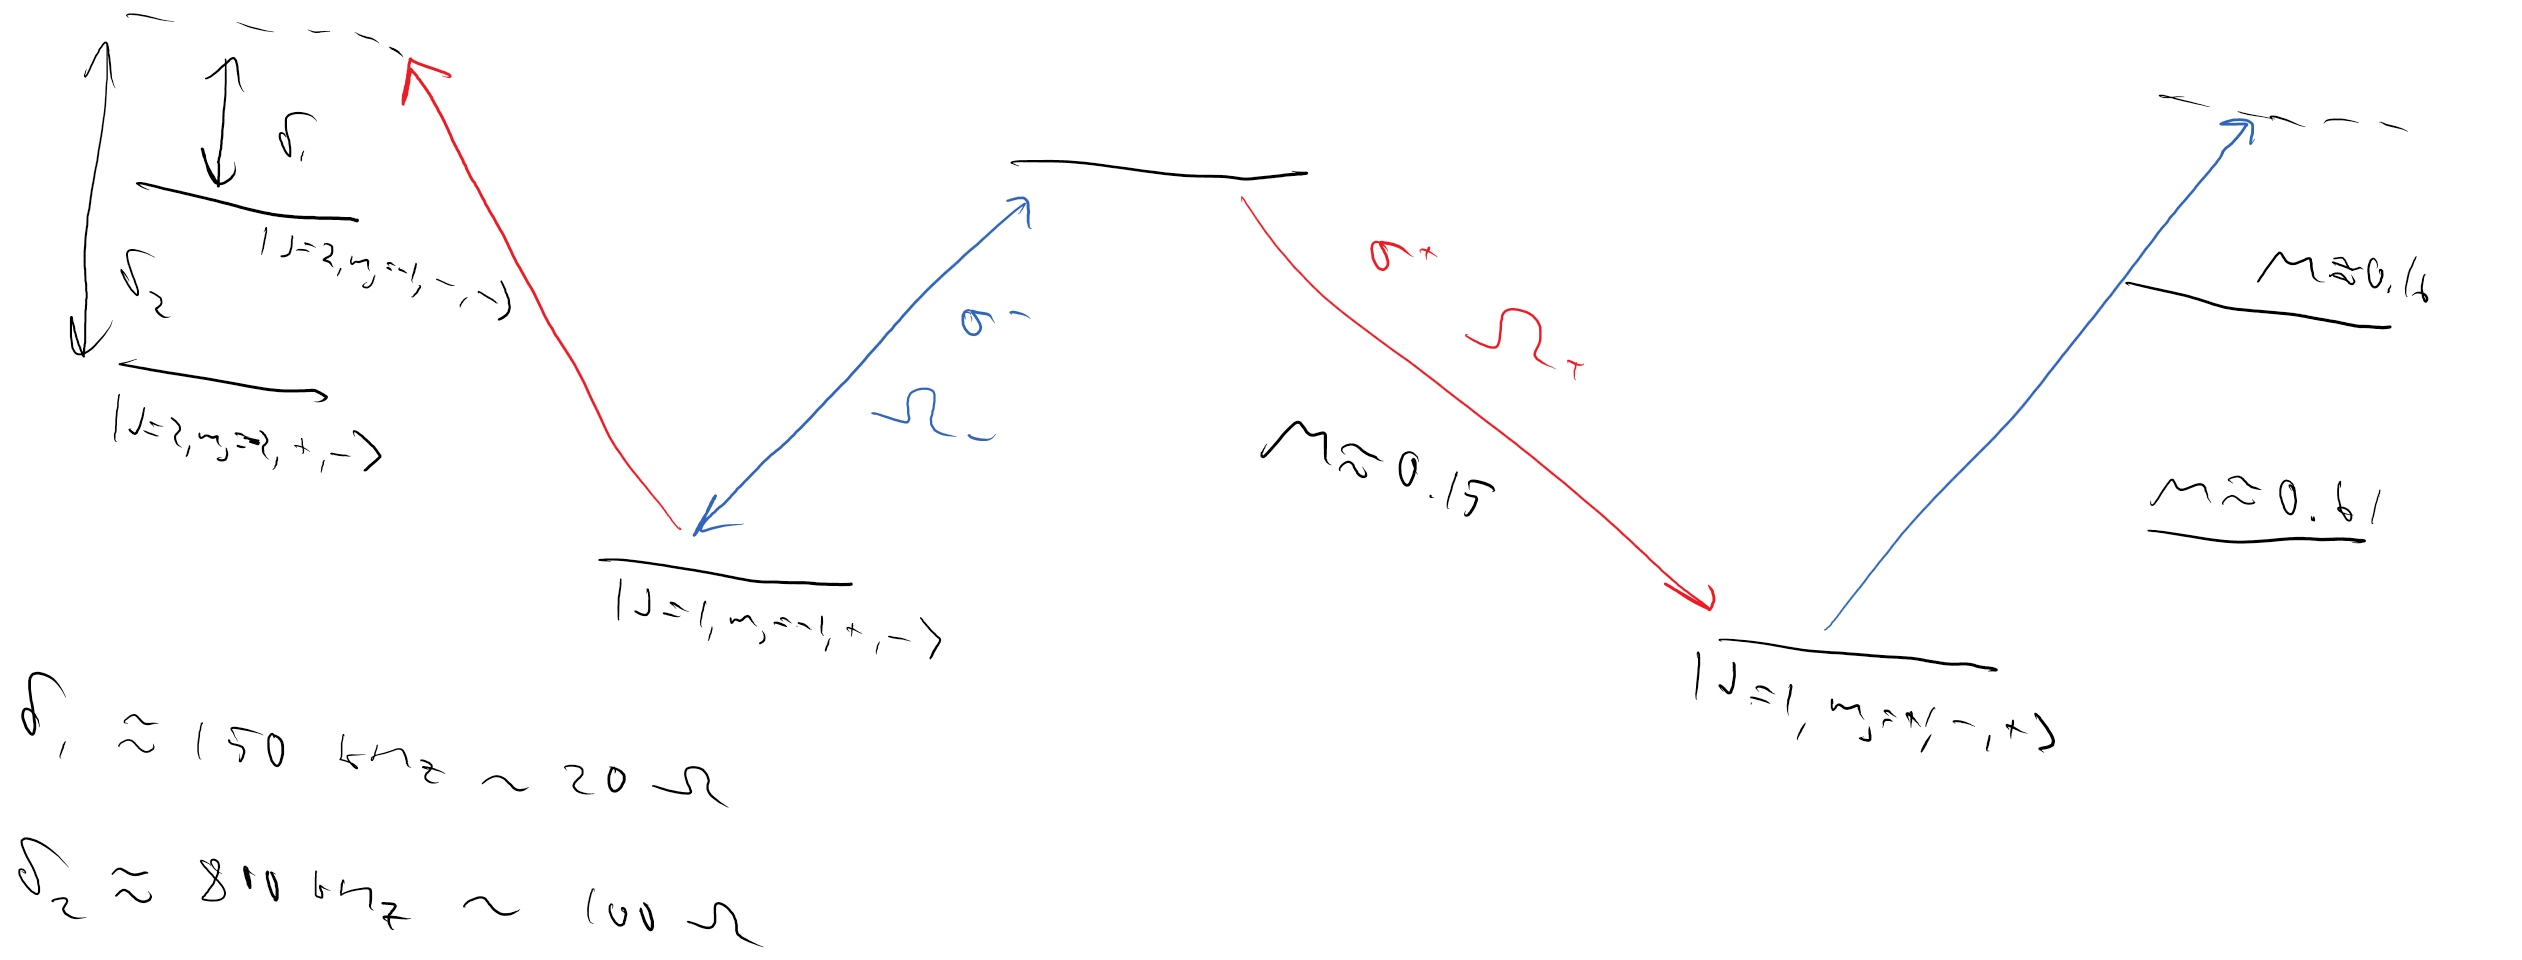

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
plt.style.use(["ggplot"])
import numpy as np
import pandas as pd
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers
from toy_systems.visualization import Visualizer

## Set up states and basis

In [2]:
# Define states
J2_singlet = BasisState(qn=ToyQuantumNumbers(label = 'J = 2, mJ = 0, S = 0'))
J1_mpm = BasisState(qn=ToyQuantumNumbers(label = 'J = 1, -+-'))
J1_pmp = BasisState(qn=ToyQuantumNumbers(label = 'J = 1, +-+'))

# Define basis
basis = Basis((J2_singlet, J1_mpm, J1_pmp))
basis.print()

|0> = |J = 2, mJ = 0, S = 0>
|1> = |J = 1, -+->
|2> = |J = 1, +-+>


## Define energies and couplings
Define the detunings of each transition from the microwaves

In [3]:
Delta_singlet = ToyEnergy([J2_singlet],1, time_dep = "k*t/2+delta", time_args = {"k":1, "delta":0})
Delta_target = ToyEnergy([J1_mpm, J1_pmp],1, time_dep = "-k*t/2-delta", time_args = {"k":1, "delta":0})
energies = [Delta_singlet, Delta_target]

Define coupling strengths for each transition:

In [4]:
# Main transition
coupling_01 = ToyCoupling(J2_singlet, J1_mpm, 1, time_dep="M0*Omega*sin(theta/2)*exp(-(t)**2/(2*sigma**2))",
                          time_args={"M0": 0.15, "theta":0, "sigma":1})
coupling_02 = ToyCoupling(J2_singlet, J1_pmp, 1, time_dep="M0*Omega*cos(theta/2)*exp(-(t)**2/(2*sigma**2))",
                          time_args={"M0": 0.15, "theta":0, "sigma":1})

couplings = [coupling_01, coupling_02]

## Define quantum system

In [5]:
# Define the system
system = QuantumSystem(basis = basis, couplings=energies+couplings, decays = [])

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Time evolution using Qutip

In [6]:
# Get a pointer to the time-evolution arguments
default_args = Hqobj.args.copy()

# Set parameters for adiabatic passage
default_args["Omega"] = 2*np.pi*5e3/default_args["M0"]
default_args["k"] = 2*np.pi*100e3/(10e-2/200)
default_args["sigma"] = np.sqrt(2)*25.4e-3/(2*np.sqrt(2*np.log(2)))/200

print("Default parameters:")
print(f"args = {default_args}")

Default parameters:
args = {'k': 1256637061.4359171, 'delta': 0, 'M0': 0.15, 'theta': 0, 'sigma': 7.627127295793956e-05, 'Omega': 209439.51023931956}


In [7]:
# Set value of theta
default_args["theta"] = np.pi/2*1

# Generate qobj representing initial state
psi0 = (1*J2_singlet).qobj(basis)

# Make operators for getting the probability of being in each state
P_J2_singlet_op = qutip.Qobj((1*J2_singlet).density_matrix(basis), type = "oper")
P_J1_mpm_op = qutip.Qobj((1*J1_mpm).density_matrix(basis), type = "oper")
P_J1_pmp_op = qutip.Qobj((1*J1_pmp).density_matrix(basis), type = "oper")
e_ops = [P_J2_singlet_op, P_J1_mpm_op, P_J1_pmp_op]

# Times at which result is requested
times = np.linspace(-5*default_args["sigma"], +5*default_args["sigma"], 1001) 

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening,
# so reduce max step size to mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = e_ops,
                      progress_bar=pb, options = options, args = default_args)

 Total run time:   0.65s*] Elapsed 0.65s / Remaining 00:00:00:00[*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00


Text(0, 0.5, 'Rabi rate / kHz')

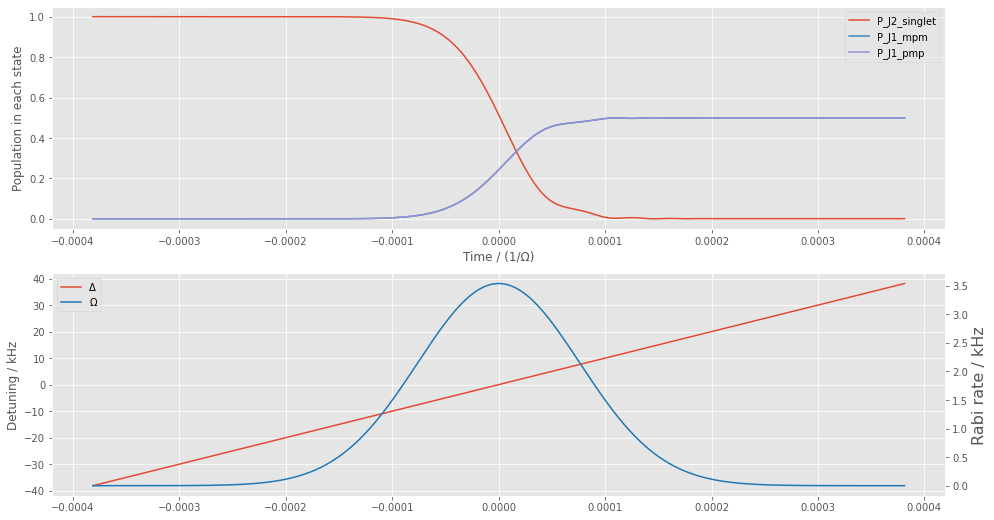

In [8]:
fig, (ax,ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_J2_singlet")
ax.plot(times, result.expect[1], label = "P_J1_mpm")
ax.plot(times, result.expect[2], label = "P_J1_pmp")

ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

# Plot the coupling strength and detuning also
ax2c = ax2.twinx()
# ax2.grid(False)
# ax2c.grid(False)
ln1 = ax2.plot(times, Delta_singlet.eval(times, default_args)/(2*np.pi*1e3), label = "Δ")
ax2.set_ylabel("Detuning / kHz")
ln2 = coupling_02.plot_time_dep(times, default_args, ax = ax2c, label = 'Ω', c = 'tab:blue', mag = 1/(2*np.pi*1e3))
ax2c.grid(False)
ax2c.set_ylabel('')
ax2.legend(ln1+ln2, [l.get_label() for l in (ln1 + ln2)])
ax2c.set_ylabel("Rabi rate / kHz")


## Polarization purity scan
Vary theta and observe probability of ending up in J1_pmp and J1_mpm

In [9]:
def parallel_func(args: dict):
    
    # Generate qobj representing initial state
    psi0 = (1*J2_singlet).qobj(basis)

    # Make operators for getting the probability of being in each state
    P_J2_singlet_op = qutip.Qobj((1*J2_singlet).density_matrix(basis), type = "oper")
    P_J1_mpm_op = qutip.Qobj((1*J1_mpm).density_matrix(basis), type = "oper")
    P_J1_pmp_op = qutip.Qobj((1*J1_pmp).density_matrix(basis), type = "oper")
    e_ops = [P_J2_singlet_op, P_J1_mpm_op, P_J1_pmp_op]

    # Times at which result is requested
    times = np.linspace(-5*args["sigma"], +5*args["sigma"], 1001) 

    # The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening,
    # so reduce max step size to mitigate this 
    options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0, rhs_reuse = True)

    # Setup a progress bar
    pb = qutip.ui.progressbar.EnhancedTextProgressBar()

    # Run the time-evolution
    result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = e_ops,
                          progress_bar=pb, options = options, args=args)
    
    return result.expect[0][-1], result.expect[1][-1], result.expect[2][-1], args["theta"]

In [10]:
thetas = np.linspace(0, np.pi, 100)
args_list = [default_args.copy()|{"theta":theta} for theta in thetas]

results = (joblib.Parallel(n_jobs = 5, backend='loky', verbose = True)(joblib.delayed(parallel_func)(args) 
                                                                                 for args in args_list))

df = pd.DataFrame(data = results, columns =  ['P_J2_singlet', 'P_J1_mpm', 'P_J1_pmp', 'theta'])

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   15.6s finished


Text(0, 0.5, 'Probability of being in given state')

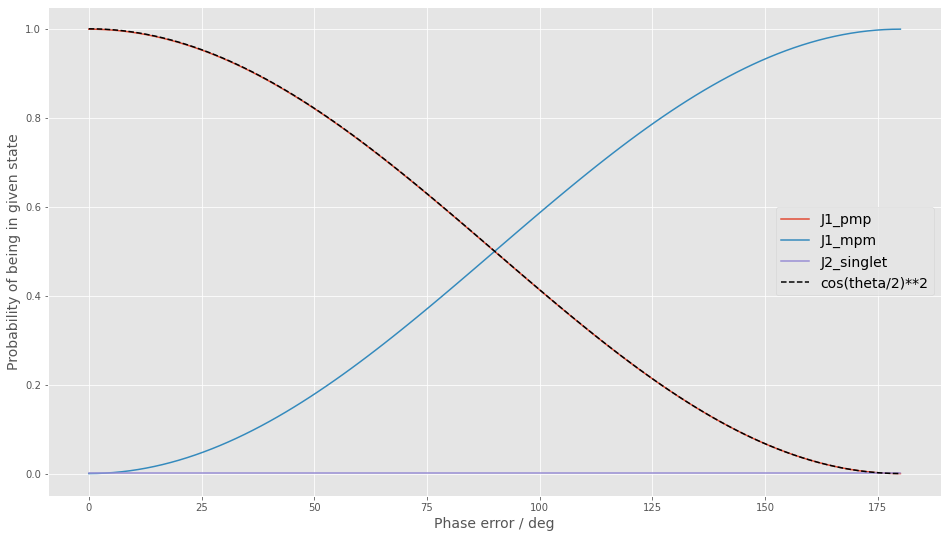

In [11]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(df.theta*180/np.pi, df.P_J1_pmp, label = 'J1_pmp')
ax.plot(df.theta*180/np.pi, df.P_J1_mpm, label = 'J1_mpm')
ax.plot(df.theta*180/np.pi, df.P_J2_singlet, label = 'J2_singlet')
ax.plot(df.theta*180/np.pi, np.cos(df.theta/2)**2, 'k--', label = 'cos(theta/2)**2')
ax.legend(fontsize = 14)
ax.set_xlabel("Phase error / deg", fontsize = 14)
ax.set_ylabel("Probability of being in given state", fontsize = 14)

In [12]:
default_args

{'k': 1256637061.4359171,
 'delta': 0,
 'M0': 0.15,
 'theta': 1.5707963267948966,
 'sigma': 7.627127295793956e-05,
 'Omega': 209439.51023931956}